# Multivariate Distributions

Apart from the `Univariate` distributions, which only work on single random variables, the **Copulas**
library supports several `Multivariate` distributions that support working with multiple random variables
at the same time, taking into account the dependencies that may exist between them.

These distributions are supported by the `Multivariate` subclasses from defined within the
`copulas.multivariate` package:

* `copulas.multivariate.GaussianMultivariate`: Implements a multivariate distribution by combining the marginal univariate distributions with a Gaussian Copula.
* `copulas.multivariate.VineCopula`: Implements a multivariate distribution using Vine Copulas.

## Gaussian Multivariate

In this example we will be using the `GaussianMultivariate` class, which implements a multivariate
distribution by using a Gaussian Copula to combine marginal probabilities estimated using `Univariate`
distributions.

Firs of all, let's load the data that we will be using later on in our examples.

This is a toy dataset with three columns following these distributions:

* `x`: Beta distribution with a=0.1 and b=0.1
* `y`: Beta distribution with a=0.1 and b=0.5
* `z`: Normal distribution + 10 times `y`

In [1]:
import warnings
warnings.filterwarnings('ignore')

In [2]:
from copulas.datasets import sample_trivariate_xyz

data = sample_trivariate_xyz()

In [3]:
data.head()

,x,y,z
0,9.004177e-05,2.883992e-06,0.638689
1,8.819273e-01,2.911979e-07,1.058121
2,5.003865e-01,4.886504e-04,0.372506
3,1.838544e-12,5.392802e-02,0.687370
4,1.627915e-01,1.634269e-08,-0.881068


<Axes3D: >

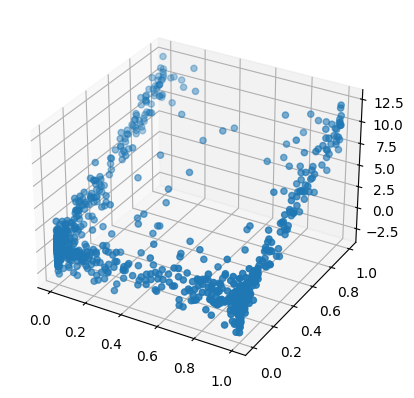

In [4]:
from copulas.visualization import scatter_3d

scatter_3d(data)

### Fitting a Model and Generating Synthetic Data

The first step to use our `GaussianUnivariate` model is to fit it to the data by passing the `data` to
its `fit` method.

In [5]:
from copulas.multivariate import GaussianMultivariate

dist = GaussianMultivariate()
dist.fit(data)

During this process, the `GaussianMultivariate` class will:

* Search for the `Univariate` distribution that better describes each column in the `data`.
* Fit the corresponding `Univariate` distributions to each column.
* Learn the join distribution based on the correlations between the marginal distributions.

After the model has been fitted, we can sample new data from it like we did with the
`Univariate` distributions.

In [6]:
sampled = dist.sample(1000)

In [7]:
sampled.head()

,x,y,z
0,4.645109e-07,6.978184e-01,5.685210
1,8.576548e-01,5.471492e-04,1.222925
2,7.158921e-18,9.926583e-01,8.710366
3,3.350572e-02,7.238915e-05,-0.978137
4,1.395064e-13,5.042386e-09,-1.521806


We can now compare the distribution of the real data to the sampled one by plotting
them side by side.

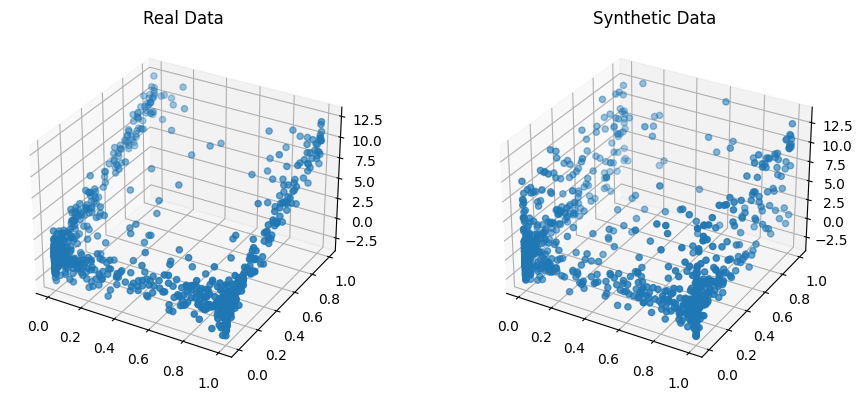

In [8]:
from copulas.visualization import compare_3d

compare_3d(data, sampled)

### Specifying column distributions

More advanced users can choose to manually specify the marginal distributions if they have
additional information about the data.

This can be done by specifying a single distribution that will be used for all the columns.

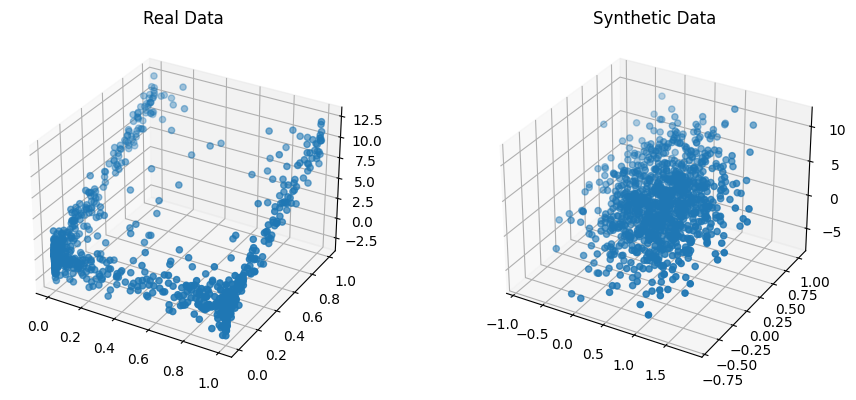

In [9]:
from copulas.univariate import GaussianUnivariate

dist = GaussianMultivariate(distribution=GaussianUnivariate)
dist.fit(data)
sampled = dist.sample(1000)

compare_3d(data, sampled)

Or by specifying the distribution that needs to be used in each column.

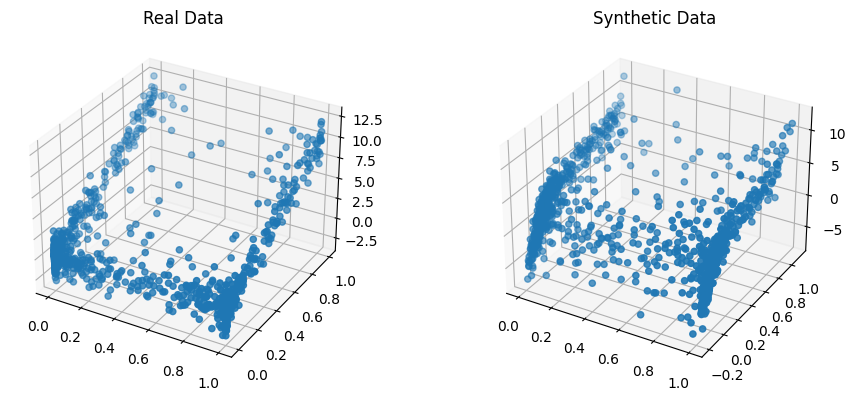

In [10]:
from copulas.univariate import BetaUnivariate, GaussianKDE, GaussianUnivariate

dist = GaussianMultivariate(distribution={
    "x": BetaUnivariate,
    "y": GaussianKDE,
    "z": GaussianUnivariate,
})
dist.fit(data)
sampled = dist.sample(1000)

compare_3d(data, sampled)

Or even by specifying a family of Univariates.

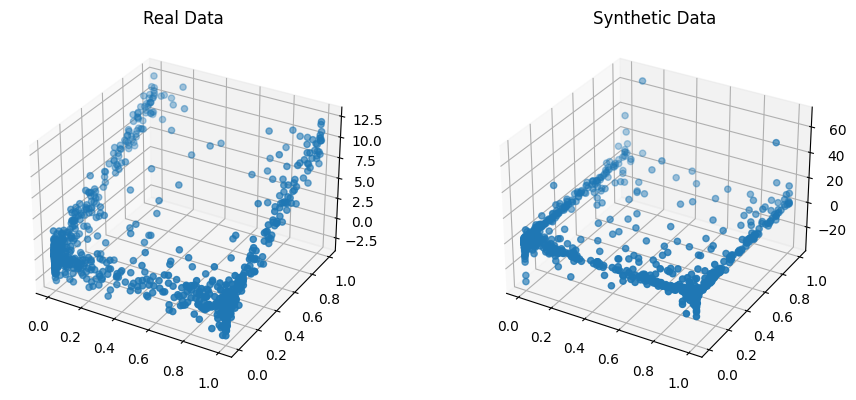

In [11]:
from copulas.univariate import ParametricType, Univariate

# Select the best PARAMETRIC univariate
univariate = Univariate(parametric=ParametricType.PARAMETRIC)

dist = GaussianMultivariate(distribution=univariate)
dist.fit(data)
sampled = dist.sample(1000)

compare_3d(data, sampled)

In general, however, letting the `Univariate` select the best model for each marginal distribution
is what produces the best results.

### Probability Density and Cumulative Distribution

The probability density and cumulative distribution can be computed for an array of data points using
the `probability_density` and `cumulative_distribution` methods respectively.

In [12]:
probability_density = dist.pdf(sampled)

In [13]:
probability_density[0:5]

array([1.42939918e-02, 8.07747559e-05, 2.49998876e-02, 9.51945678e-03,
       2.97103458e-02])

In [14]:
cumulative_distribution = dist.cumulative_distribution(sampled)

In [15]:
cumulative_distribution[0:5]

array([0.01790582, 0.00566969, 0.19175434, 0.15688468, 0.23180056])

### to_dict and from_dict

Like `Univariate`, `Multivariate` classes implement a `to_dict` method that allows
obtaining all the parameters that define the distribution in a python dictionary.

In [16]:
parameters = dist.to_dict()
parameters.keys()

dict_keys(['correlation', 'univariates', 'columns', 'type'])

In the case of `GaussianMultivariate`, this contains information about the correlation that
defines the join distribution:

In [17]:
parameters['correlation']

[[1.0, -0.02150819956064483, -0.03904683794009118],
 [-0.02150819956064483, 1.0, 0.7098648029301189],
 [-0.03904683794009118, 0.7098648029301189, 1.0]]

And the parameters of the univariates used for each column:

In [18]:
parameters['univariates']

[{'loc': 1.3765984634140217e-23,
  'scale': 1.0000000000000002,
  'a': 0.09657613485947786,
  'b': 0.10226371906556,
  'type': 'copulas.univariate.beta.BetaUnivariate'},
 {'loc': 2.619420845777311e-49,
  'scale': 0.999986655706105,
  'a': 0.11353643335098351,
  'b': 0.5621697120496405,
  'type': 'copulas.univariate.beta.BetaUnivariate'},
 {'df': 1.4006628830710697,
  'loc': 0.4691588432897164,
  'scale': 1.247945331065269,
  'type': 'copulas.univariate.student_t.StudentTUnivariate'}]

Finally, this `parameters` dictionary can be later on passed to the `Multivariate.from_dict` class
method, which will create an instance of our model with the same parameters as before.

In [19]:
from copulas.multivariate import Multivariate

new_dist = Multivariate.from_dict(parameters)

In [20]:
new_dist

GaussianMultivariate()

## Vine Copulas

In addition, **Copulas** also implements Vine Copulas. The Vine copulas work by building a [vine](https://en.wikipedia.org/wiki/Vine_copula) (a set of trees) over the different columns in the dataset and estimating the pairwise (i.e. bivariate) relationship between the nodes on every edge.

There are three types of Vine copulas: *direct*, *regular*, and *center*.

In [21]:
from copulas.multivariate import VineCopula

center = VineCopula('center')
regular = VineCopula('regular')
direct = VineCopula('direct')

center.fit(data)
regular.fit(data)
direct.fit(data)

center_samples = center.sample(1000)
regular_samples = regular.sample(1000)
direct_samples = direct.sample(1000)

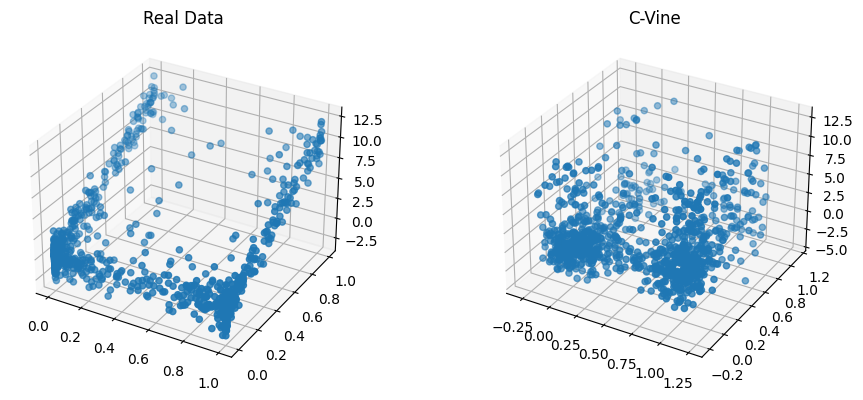

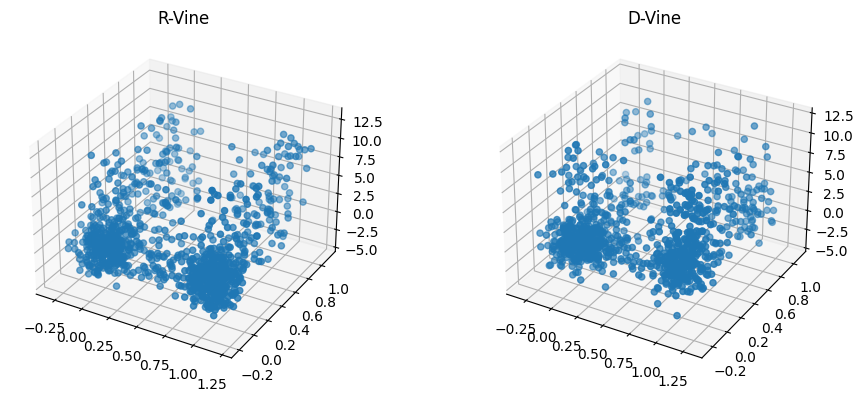

In [22]:
from copulas.visualization import side_by_side

side_by_side(scatter_3d, {'Real Data': data, 'C-Vine': center_samples})
side_by_side(scatter_3d, {'R-Vine': regular_samples, 'D-Vine': direct_samples})